### Lev Data Science Challenge
### Ercong Luo
### Notebook created: April 8, 2022

In [117]:
# setup, see `README.md` for package downloads for this notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import spacy
from pandarallel import pandarallel # my laptop has 8 CPU cores, so i wanna take advantage of this, documentation: https://github.com/nalepae/pandarallel
import time
import ipywidgets # to show progress bars
import nltk 
from nltk.stem.porter import * # stemming
nltk.download('wordnet')  # stemming
nltk.download('omw-1.4')  # stemming
from nltk import bigrams # co-occurence
import itertools
from sklearn.linear_model import Perceptron # model ?
from sklearn.naive_bayes import MultinomialNB # model ?
from sklearn.feature_extraction.text import TfidfVectorizer # text to Tf-idf scores
import re # cleaning text
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from gensim.models.doc2vec import Doc2Vec # for wine review clustering
from gensim.models.doc2vec import TaggedDocument # for wine review clustering
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorboard.plugins import projector
from wordcloud import WordCloud # text viz



print("Kernel is correct (True/False):", os.environ['CONDA_DEFAULT_ENV'] == 'lev-data-challenge')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ercongluo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ercongluo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Kernel is correct (True/False): True


In [2]:
# read in data
dat = pd.read_json('winemag-data-130k-v2.json')

# print dataframe dimension
print(dat.shape)

# preview head
dat.head(5)

(129971, 13)


,points,title,description,taster_name,taster_twitter_handle,price,designation,variety,region_1,region_2,province,country,winery
0,87,Nicosia 2013 Vulkà Bianco (Etna),"Aromas include tropical fruit, broom, brimston...",Kerin O’Keefe,@kerinokeefe,NaN,Vulkà Bianco,White Blend,Etna,None,Sicily & Sardinia,Italy,Nicosia
1,87,Quinta dos Avidagos 2011 Avidagos Red (Douro),"This is ripe and fruity, a wine that is smooth...",Roger Voss,@vossroger,15.0,Avidagos,Portuguese Red,None,None,Douro,Portugal,Quinta dos Avidagos
2,87,Rainstorm 2013 Pinot Gris (Willamette Valley),"Tart and snappy, the flavors of lime flesh and...",Paul Gregutt,@paulgwine,14.0,None,Pinot Gris,Willamette Valley,Willamette Valley,Oregon,US,Rainstorm
3,87,St. Julian 2013 Reserve Late Harvest Riesling ...,"Pineapple rind, lemon pith and orange blossom ...",Alexander Peartree,None,13.0,Reserve Late Harvest,Riesling,Lake Michigan Shore,None,Michigan,US,St. Julian
4,87,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,"Much like the regular bottling from 2012, this...",Paul Gregutt,@paulgwine,65.0,Vintner's Reserve Wild Child Block,Pinot Noir,Willamette Valley,Willamette Valley,Oregon,US,Sweet Cheeks


# Part 1
## Provide an overview of the data, are there any quality issues? Perform any necessary cleanup of the data if applicable.

According to `README.md`, the most important features are the following: 

- `title` - wine name will be used for clustering in Part 4. 
- `description` - used to extract wine taste notes. 
- `variety` - needed for training the grape-variety pair prediction model
- `region_1`, `region_2`, `oprovince`, `country` - geographical features needed for training the grape-variety pair prediction model

In [3]:
# data cleaning #1: remove duplicate rows
dat.drop_duplicates(inplace = True)
print(129971 - dat.shape[0], 'rows of duplicate data are dropped')
print(dat.shape)

9983 rows of duplicate data are dropped
(119988, 13)


In [4]:
# data cleaning #2: take out irrelevant columns
dat.drop(labels = ['points',
                  'taster_name',
                  'taster_twitter_handle',
                  'price'],
         inplace = True,
         axis = 1)

# preview dataframe again
dat.head(5)

,title,description,designation,variety,region_1,region_2,province,country,winery
0,Nicosia 2013 Vulkà Bianco (Etna),"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,White Blend,Etna,None,Sicily & Sardinia,Italy,Nicosia
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),"This is ripe and fruity, a wine that is smooth...",Avidagos,Portuguese Red,None,None,Douro,Portugal,Quinta dos Avidagos
2,Rainstorm 2013 Pinot Gris (Willamette Valley),"Tart and snappy, the flavors of lime flesh and...",None,Pinot Gris,Willamette Valley,Willamette Valley,Oregon,US,Rainstorm
3,St. Julian 2013 Reserve Late Harvest Riesling ...,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,Riesling,Lake Michigan Shore,None,Michigan,US,St. Julian
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,Pinot Noir,Willamette Valley,Willamette Valley,Oregon,US,Sweet Cheeks


In [5]:
# how many missing values each column?
dat.isna().sum()

title              0
description        0
designation    34545
variety            1
region_1       19560
region_2       73219
province          59
country           59
winery             0
dtype: int64

In [6]:
# print the row missing important feature `variety`
dat.loc[dat.variety.isna(),:]

,title,description,designation,variety,region_1,region_2,province,country,winery
86909,Carmen 1999 (Maipo Valley),"A chalky, dusty mouthfeel nicely balances this...",None,None,None,None,Maipo Valley,Chile,Carmen


In [7]:
# data cleaning #3: drop the row with missing important feature `variety`
dat.drop(labels = [86909], 
         axis = 0,
         inplace = True)

In [8]:
# One can deduce the country where the wine is from using `designation`
print(f"There are {np.sum((dat.country.isna() == True) & (dat.designation.isna() == False))} rows of data where the feature `country` is missing.")
print("Here are some examples:")
dat.loc[dat.country.isna() == True, :].head(5)

There are 49 rows of data where the feature `country` is missing.
Here are some examples:


,title,description,designation,variety,region_1,region_2,province,country,winery
913,Gotsa Family Wines 2014 Asureti Valley Chinuri,"Amber in color, this wine has aromas of peach ...",Asureti Valley,Chinuri,None,None,None,None,Gotsa Family Wines
3131,Barton & Guestier NV Partager Red,"Soft, fruity and juicy, this is a pleasant, si...",Partager,Red Blend,None,None,None,None,Barton & Guestier
4243,Kakhetia Traditional Winemaking 2012 Red Natur...,"Violet-red in color, this semisweet wine has a...",Red Naturally Semi-Sweet,Ojaleshi,None,None,None,None,Kakhetia Traditional Winemaking
9509,Tsililis 2015 Theopetra Malagouzia-Assyrtiko W...,This mouthwatering blend starts with a nose of...,Theopetra Malagouzia-Assyrtiko,White Blend,None,None,None,None,Tsililis
9750,Ross-idi 2015 Orange Nikolaevo Vineyard Chardo...,This orange-style wine has a cloudy yellow-gol...,Orange Nikolaevo Vineyard,Chardonnay,None,None,None,None,Ross-idi


Because `country` is an important feature, it is pretty worth it to put in the effort to imputate missing values in a real-world project. One way is to just google the wine using `title` or `designation` to see what the country is. Below is an example where I found the country for the wine `Gotsa Family Wines 2014 Asureti Valley Chinuri`, which happens to be Georgia. 

![example where I found the wine using Google](imputation.png)

In [9]:
# data cleaning (imputation) #4: making educated guesses on rows where the `country` feature is missing
dat.loc[dat.title == 'Gotsa Family Wines 2014 Asureti Valley Chinuri', 'country'] = 'Georgia'
dat.loc[dat.title == 'Gotsa Family Wines 2014 Asureti Valley Chinuri', 'province'] = 'Kvemo Kartli'
dat.loc[dat.title == 'Gotsa Family Wines 2014 Asureti Valley Chinuri']

,title,description,designation,variety,region_1,region_2,province,country,winery
913,Gotsa Family Wines 2014 Asureti Valley Chinuri,"Amber in color, this wine has aromas of peach ...",Asureti Valley,Chinuri,None,None,Kvemo Kartli,Georgia,Gotsa Family Wines


If given more time, imputation for missing `country` entries could be continued in the way I described above. Maybe another efficient way would be to get access to a database of wines, and fill in missing values where the database has the corresponding information.

But for now, the rows with missing `country` feautures will be dropped. 

In [10]:
# data cleaning #4 continued: drop rows where `country` feature is missing
prev = dat.shape[0]
dat.dropna(subset = 'country', inplace = True)
print(f"{prev - dat.shape[0]} rows are dropped for missing key feature `country`")

58 rows are dropped for missing key feature `country`


In [11]:
# how many missing values per column now?
dat.isna().sum()

title              0
description        0
designation    34534
variety            0
region_1       19501
region_2       73160
province           0
country            0
winery             0
dtype: int64

In [12]:
# how many unique values each column?
print(dat.nunique(dropna=True))

title          118781
description    119896
designation     37955
variety           701
region_1         1229
region_2           17
province          426
country            43
winery          16745
dtype: int64


In [13]:
# data cleaning #5: regex text cleaning on `description`
dat.description = dat.description.str.replace("[^a-zA-ZÀ-ÿ0-9, ]", '', regex = True) # only keep {letters, accented letters, numbers, commas, spaces}

# Part 2

## 2.1 Extract the most relevant descriptive labels for each wine, for example: "tannic", "lemon", "tart", "bone dry", "unripe pineapple"

In [14]:
# time to use spaCy to help with extraction descriptive labels: 
# the solution approach is to use Part-of-Speech (POS) tagging to help get descriptive word combinations
nlp = spacy.load('en_core_web_sm') # load up spacy for tokenization, 'md' is for 'medium' (here the medium-sized model is used)

In [15]:
# using a sample description as demo
demo = nlp(dat.description[0]) # tokenize this description

# POS tag is built into the spacy tokenization:
print([(token, token.pos_) for token in demo])

[(Aromas, 'NOUN'), (include, 'VERB'), (tropical, 'ADJ'), (fruit, 'NOUN'), (,, 'PUNCT'), (broom, 'NOUN'), (,, 'PUNCT'), (brimstone, 'NOUN'), (and, 'CCONJ'), (dried, 'VERB'), (herb, 'NOUN'), (The, 'DET'), (palate, 'NOUN'), (is, 'AUX'), (nt, 'PART'), (overly, 'ADV'), (expressive, 'ADJ'), (,, 'PUNCT'), (offering, 'VERB'), (unripened, 'ADJ'), (apple, 'NOUN'), (,, 'PUNCT'), (citrus, 'NOUN'), (and, 'CCONJ'), (dried, 'VERB'), (sage, 'NOUN'), (alongside, 'ADP'), (brisk, 'ADJ'), (acidity, 'NOUN')]


In [16]:
def get_labels(string):
    """
    A brute-force solution I attempted to grab all descriptors of a wine only using POS tags. But there is a better solution below, called get_descriptors(). 
    
    This function takes in a string of text and returns the following word combinations as a list: 
      - NOUN, e.g. citrus
      - ADJ, delicious
      - ADV + ADJ, overly herbal
      - ADJ + NOUN, e.g. tropical fruit
      - VERB + NOUN, e.g. dried sage (dried is considered a verb)
      - ADJ + ADJ + NOUN combinations, e.g. tropical fresh berries 
    """
    string = string.lower()
    labels = list()
    tokenized_string = nlp(string)
    n = len(tokenized_string)
    i = 0
    while i < n:
        if tokenized_string[i].pos_ == 'ADJ':
            if (i+1 < n) and (tokenized_string[i+1].pos_ == 'NOUN'):
                labels.append(str(tokenized_string[i]) + ' ' + str(str(tokenized_string[i+1]))) # get ADJ + NOUN combinations
                i = i+2
            elif (i+1 < n) and (tokenized_string[i+1].pos_ == 'ADJ') and (i+2 < n) and (tokenized_string[i+2].pos_ == 'NOUN'):
                labels.append(str(tokenized_string[i]) + ' ' + str(str(tokenized_string[i+1]))) # get ADJ + ADJ + NOUN combinations
                i = i+3
            else:
                labels.append(str(tokenized_string[i])) # get stand-alone ADJ words
                i = i+1
        elif tokenized_string[i].pos_ == 'ADV':
            if (i+1 < n) and (tokenized_string[i+1].pos_ == 'ADJ'): 
                labels.append(str(tokenized_string[i]) + ' ' + str(str(tokenized_string[i+1]))) # get ADV + ADJ combinations
                i = i+2
            else:
                i = i+1
        elif tokenized_string[i].pos_ == 'VERB':
            if (i+1 < n) and (tokenized_string[i+1].pos_ == 'NOUN'): 
                labels.append(str(tokenized_string[i]) + ' ' + str(str(tokenized_string[i+1]))) # get ADV + ADJ combinations
                i = i+2
            else:
                i = i+1
        elif tokenized_string[i].pos_ == 'NOUN':
            labels.append(str(tokenized_string[i])) # get stand-alone NOUN words
            i = i+1
        else:
            i = i+1
    
    return set(labels)

# use a list of stopwords for getting descriptors
stopwords = nlp.Defaults.stop_words

# add more stopwords that I found through examples
stopwords |= {'aroma','aromas',
                'flavor','flavors',
                'note','notes',
                'food',
                'touch',
                'wine',
                "it's"
                 }

def get_descriptors(string):
    """
    This function uses tools provided by spaCy to grab all adjectives and noun chunks in the string that describes a wine. 
    Returns all descriptors as a list. 
    """
    
    string = string.lower() # make all descriptors lower-case
    spacy_tokens = nlp(string) # use spaCy to tokenize the string, comes with `token.{pos_, lemma_}` that I will use
    noun_chunks = spacy_tokens.noun_chunks # get all noun chunks in the string
    
    toReturn = [] # initialize list of descriptors to return
    for chunk in noun_chunks: 
        if all((str(token) not in stopwords) and  # no token in the noun chunk can be a stopword
               token.is_punct != True and # no token in the noun chunk can be punctuation
               '-PRON-' not in token.lemma_ # no token in the noun chunk can be a pronoun
               for token in chunk # conditions above must hold for each token in the noun chunk
        ) == True:
            toReturn.append(str(chunk)) # then this noun chunk can be returned
    
    # there are still stand-alone adjectives which weren't used to describe any nouns but not returned, I want them too
    # below is the solution 
    
    already_in_noun_chunks = [word for token in toReturn for word in str(token).split()] # get all words that the noun chunks already contain into a list
    for token in spacy_tokens:
        if (token.pos_ == 'ADJ') & (str(token) not in already_in_noun_chunks): # if a token in the string is an adjective and not already in the list to be returned
            toReturn.append(str(token))

    return list(toReturn)


In [17]:
# demo of get_descriptors()
for i in range(3):
    print('Sentence:', dat.description[i])
    print(get_descriptors(dat.description[i]))
    print('------------------------------------------')

Sentence: Aromas include tropical fruit, broom, brimstone and dried herb The palate isnt overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity
['tropical fruit', 'broom', 'brimstone', 'dried herb', 'unripened apple', 'citrus', 'dried sage', 'brisk acidity', 'expressive']
------------------------------------------
Sentence: This is ripe and fruity, a wine that is smooth while still structured Firm tannins are filled out with juicy red berry fruits and freshened with acidity Its  already drinkable, although it will certainly be better from 2016
['firm tannins', 'juicy red berry fruits', 'acidity', 'ripe', 'smooth', 'drinkable', 'better']
------------------------------------------
Sentence: Tart and snappy, the flavors of lime flesh and rind dominate Some green pineapple pokes through, with crisp acidity underscoring the flavors The wine was all stainlesssteel fermented
['lime flesh', 'rind', 'crisp acidity', 'snappy', 'green', 'stainlesssteel']
------

In [18]:
# This is a costly operation to run over all 200,000-ish rows, so here's a demo of run-time improvement using parallelization on pandas

# use a subset of 1000 rows to demonstrate performance improvement 
temp = dat.head(1000)

t0 = time.time()
tqdm.pandas()
labels = temp['description'].progress_apply(get_descriptors)
t1 = time.time()
print(f"Without parallelization, this operation took {t1-t0}s")

t0 = time.time()
pandarallel.initialize(progress_bar=True) # initialize parallelization config based on the machine, my local machine has 8 CPU cores
labels = temp['description'].parallel_apply(get_descriptors)
t1 = time.time()
print(f"With parallelization, this operation took {t1-t0}s")

del(temp)
del(labels)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.97it/s]

Without parallelization, this operation took 7.83128809928894s
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


With parallelization, this operation took 1.5426199436187744s


In [19]:
# apply get_descriptors() to all entries in column 'description', THIS MIGHT TAKE A BIT TIME
t0 = time.time()
pandarallel.initialize(progress_bar=True) # initialize parallelization config based on the machine
labels = dat['description'].parallel_apply(get_descriptors) # apply get_labels() to all descriptions
t1 = time.time()
print(f"this operation took {t1-t0}s")

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


this operation took 237.6213059425354s


In [20]:
# assign flavor `note` column to extracted descriptive labels
dat['notes'] = labels

## 2.2 Do certain geographies and labels have high co-occurence?


In [21]:
# preview what the data looks like now
dat.head(5)

,title,description,designation,variety,region_1,region_2,province,country,winery,notes
0,Nicosia 2013 Vulkà Bianco (Etna),"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,White Blend,Etna,None,Sicily & Sardinia,Italy,Nicosia,"[tropical fruit, broom, brimstone, dried herb,..."
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),"This is ripe and fruity, a wine that is smooth...",Avidagos,Portuguese Red,None,None,Douro,Portugal,Quinta dos Avidagos,"[firm tannins, juicy red berry fruits, acidity..."
2,Rainstorm 2013 Pinot Gris (Willamette Valley),"Tart and snappy, the flavors of lime flesh and...",None,Pinot Gris,Willamette Valley,Willamette Valley,Oregon,US,Rainstorm,"[lime flesh, rind, crisp acidity, snappy, gree..."
3,St. Julian 2013 Reserve Late Harvest Riesling ...,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,Riesling,Lake Michigan Shore,None,Michigan,US,St. Julian,"[pineapple rind, honeydrizzled guava, mango, w..."
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,Pinot Noir,Willamette Valley,Willamette Valley,Oregon,US,Sweet Cheeks,"[regular, rough, tannic, rustic, earthy, herba..."


My thoughts on performing feature engineering on `notes` column. 

1. **Stem all word tokens**. The words with the same root word are semantically similar enough that they should be treated the same way: fruit <=> fruits, herb <=> herbs <=> herbal. This way the (geograhy, label) co-occurences of (Italy, fruit) and (Italy, fruity) are treated the same way. 
2. What is the unit of a token, one word or one flavor note? E.g. is `tropical fruit` one single token, or should it be two separate tokens? My thought is the token unit should be flavor notes rather than individual English words. Some examples: 
    - `pineapple rind` is a very different taste from just `pineapple` or just `rind`. 
    - `dried herb` after stemming will be `dry herb`. When `dry` is taken out of the context of `dried herb`, the semantics can be misleading to say that the wine tastes dry in texture instead of the intended meaning of the wine has `dried herb` aroma. 

In [22]:
stemmer = PorterStemmer() # use the nltk stemmer to perform stemming
def list_to_stemmed_list(LIST):
    """
    Takes a list of flavor notes, lemmatizes each word, and then returns the lemmatized flavor notes as a list. 
    """
    toReturn = []
    for note in LIST:
        toReturn.append(' '.join([stemmer.stem(word) for word in note.split()])) # lemmatize each component word of a flavor note, put the lemmatized words back into one single phrase, then append to returned list
    return toReturn

# demo: 
foo = ["bananas and oranges", "tropical fruits", 'firm tannins', 'juicy red berry fruits']
print(f"The original list is: {foo}. \n After Lemmatization the list becomes: {list_to_stemmed_list(foo)}")

The original list is: ['bananas and oranges', 'tropical fruits', 'firm tannins', 'juicy red berry fruits']. 
 After Lemmatization the list becomes: ['banana and orang', 'tropic fruit', 'firm tannin', 'juici red berri fruit']


In [23]:
# perform stemming on `notes`
t0 = time.time()
pandarallel.initialize(progress_bar=True) # initialize parallelization config based on the machine, my local machine has 8 CPU cores
stemmed_notes = dat['notes'].parallel_apply(list_to_stemmed_list)
t1 = time.time()
print(f"This operation took {t1-t0}s")

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


This operation took 12.239707946777344s


In [24]:
dat['X'] = stemmed_notes # stemmed_notes are to be used as input feature, it's why I named it X
dat.head(5)

,title,description,designation,variety,region_1,region_2,province,country,winery,notes,X
0,Nicosia 2013 Vulkà Bianco (Etna),"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,White Blend,Etna,None,Sicily & Sardinia,Italy,Nicosia,"[tropical fruit, broom, brimstone, dried herb,...","[tropic fruit, broom, brimston, dri herb, unri..."
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),"This is ripe and fruity, a wine that is smooth...",Avidagos,Portuguese Red,None,None,Douro,Portugal,Quinta dos Avidagos,"[firm tannins, juicy red berry fruits, acidity...","[firm tannin, juici red berri fruit, acid, rip..."
2,Rainstorm 2013 Pinot Gris (Willamette Valley),"Tart and snappy, the flavors of lime flesh and...",None,Pinot Gris,Willamette Valley,Willamette Valley,Oregon,US,Rainstorm,"[lime flesh, rind, crisp acidity, snappy, gree...","[lime flesh, rind, crisp acid, snappi, green, ..."
3,St. Julian 2013 Reserve Late Harvest Riesling ...,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,Riesling,Lake Michigan Shore,None,Michigan,US,St. Julian,"[pineapple rind, honeydrizzled guava, mango, w...","[pineappl rind, honeydrizzl guava, mango, way,..."
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,Pinot Noir,Willamette Valley,Willamette Valley,Oregon,US,Sweet Cheeks,"[regular, rough, tannic, rustic, earthy, herba...","[regular, rough, tannic, rustic, earthi, herba..."


In [25]:
def generate_co_occurrence_matrix(feature, data_ll: list):
    """
    'feature' can be 'country', 'province', 'region', etc
    'data_ll' is a list of lists, each component list is a list of flavor notes. 
    This function returns the co-occurence matrix
    """
    data_l = list(itertools.chain.from_iterable(data_ll)) # data is the flattened version of `text_data`
    vocab_y = dat[feature].unique().tolist()
    vocab_x = list(set(data_l)) # take out repetition of words

    vocab_index_x = {word: i for i, word in enumerate(vocab_x)} # dict: <word, x-position> pairs
    vocab_index_y = {word: i for i, word in enumerate(vocab_y)} # dict: <word, y-position> pairs
    
    co_occurrence_matrix = np.zeros((len(vocab_x), len(vocab_y))) # preallocate co-occurence matrix
    
    for j in range(len(vocab_y)): # for each country, or province, or whatever 'feature' is
        subset_mask = (dat[feature] == vocab_y[j]) # mask according dataframe and current feature value
        temp = list(itertools.compress(data_ll, subset_mask)) # subset the corpus `data_ll` based on row numbers
        
        for sublist in temp: 
            for flavor_note in sublist: 
                x_index = vocab_index_x[flavor_note]
                co_occurrence_matrix[x_index, j] += 1
    
    return co_occurrence_matrix.astype(int), vocab_index_x, vocab_index_y

In [26]:
def get_highest_co_occurence(feature, data_ll: list, num = 10):
    matrix, x_index, y_index = generate_co_occurrence_matrix(feature, data_ll)
    co_occurence_df = pd.DataFrame(matrix, 
                               index=x_index,
                                 columns=y_index)
    co_occurence_df.index.name = 'note'
    co_occurence_df.reset_index(inplace=True)

    country_cooc = pd.melt(co_occurence_df, 
                           id_vars = 'note', 
                           value_vars = co_occurence_df.columns[1:], 
                           var_name = feature, 
                           value_name = 'joint occurence')
    print(country_cooc.sort_values('joint occurence', ascending = False).head(num))

### a. By `country`

In [27]:
data_ll = dat.notes.tolist() # put `X` column which contains stemmed flavor notes into a list
data_ll_root = dat.X.tolist() # these are the non-stemmed, original flavor notes from the descriptions
print('By raw flavor notes, these are the highest co-occurences.')
get_highest_co_occurence('country', data_ll)
print('---------------------------------------------------------') 
print('By the word roots of flavor notes, these are the highest co-occurences.') 
get_highest_co_occurence('country', data_ll_root)

By raw flavor notes, these are the highest co-occurences.
           note country  joint occurence
271556      dry      US             6906
261651     rich      US             6052
452883     ripe  France             5366
255079     ripe      US             5037
210538     soft      US             4691
241046    sweet      US             4635
459455     rich  France             4139
435100     full  France             3153
213859  vanilla      US             3125
412761    crisp  France             3066
---------------------------------------------------------
By the word roots of flavor notes, these are the highest co-occurences.
          note country  joint occurence
227732     dri      US             6927
243501    rich      US             6465
421773    ripe  France             5485
237521    ripe      US             5301
224535   sweet      US             5012
196198    soft      US             4743
427753    rich  France             4705
227319  cherri      US             4608
1

### b. By `province`

In [41]:
print('By raw flavor notes, these are the highest co-occurences.')
get_highest_co_occurence('province', data_ll)
print('---------------------------------------------------------') 
print('By the word roots of flavor notes, these are the highest co-occurences.') 
get_highest_co_occurence('province', data_ll_root)

By raw flavor notes, these are the highest co-occurences.
           note    province  joint occurence
766066      dry  California             5614
756161     rich  California             4967
705048     soft  California             3836
749589     ripe  California             3819
735556    sweet  California             3593
764303     good  California             2557
786014   tannic  California             2258
708108  acidity  California             2249
708369  vanilla  California             2079
785348  complex  California             1993
---------------------------------------------------------
By the word roots of flavor notes, these are the highest co-occurences.
              note    province  joint occurence
688362         dri  California             5627
704131        rich  California             5288
698151        ripe  California             4049
656828        soft  California             3880
685165       sweet  California             3848
687949      cherri  Californi

### c. By `region_1`

In [29]:
print('By raw flavor notes, these are the highest co-occurences.')
get_highest_co_occurence('region_1', data_ll)
print('---------------------------------------------------------') 
print('By the word roots of flavor notes, these are the highest co-occurences.') 
get_highest_co_occurence('region_1', data_ll_root)

By raw flavor notes, these are the highest co-occurences.
          note              region_1  joint occurence
756161    rich           Napa Valley              817
766066     dry           Napa Valley              760
667164     dry                Alsace              701
705048    soft           Napa Valley              607
3900420  sweet            California              555
749589    ripe           Napa Valley              526
3930930    dry            California              503
3478723  crisp             Champagne              472
7590304    dry  Russian River Valley              449
3518845   ripe             Champagne              439
---------------------------------------------------------
By the word roots of flavor notes, these are the highest co-occurences.
               note              region_1  joint occurence
704131         rich           Napa Valley              855
688362          dri           Napa Valley              760
596236          dri                Alsace

### d. By `region_2`

In [30]:
print('By raw flavor notes, these are the highest co-occurences.')
get_highest_co_occurence('region_2', data_ll)
print('---------------------------------------------------------') 
print('By the word roots of flavor notes, these are the highest co-occurences.') 
get_highest_co_occurence('region_2', data_ll_root)

By raw flavor notes, these are the highest co-occurences.
        note       region_2  joint occurence
370458   dry         Sonoma             1527
469360   dry  Central Coast             1398
459455  rich  Central Coast             1346
360553  rich         Sonoma             1208
261651  rich           Napa             1189
271556   dry           Napa             1150
452883  ripe  Central Coast             1000
309440  soft         Sonoma              995
210538  soft           Napa              956
353981  ripe         Sonoma              939
---------------------------------------------------------
By the word roots of flavor notes, these are the highest co-occurences.
          note         region_2  joint occurence
319858     dri           Sonoma             1527
427753    rich    Central Coast             1418
411984     dri    Central Coast             1409
335627    rich           Sonoma             1295
243501    rich             Napa             1246
805451    herb  Columbi

## 2.3 Do certain grape varietals and labels have high co-occurence?

In [31]:
print('By raw flavor notes, these are the highest co-occurences.')
get_highest_co_occurence('variety', data_ll)
print('---------------------------------------------------------') 
print('By the word roots of flavor notes, these are the highest co-occurences.') 
get_highest_co_occurence('variety', data_ll_root)

By raw flavor notes, these are the highest co-occurences.
          note                   variety  joint occurence
1052867   rich                Chardonnay             1719
1046295   ripe                Chardonnay             1709
3123237   ripe  Bordeaux-style Red Blend             1494
452883    ripe                Pinot Noir             1444
370458     dry                  Riesling             1439
1006173  crisp                Chardonnay             1397
469360     dry                Pinot Noir             1361
459455    rich                Pinot Noir             1320
3129809   rich  Bordeaux-style Red Blend             1164
855063    rich        Cabernet Sauvignon             1148
---------------------------------------------------------
By the word roots of flavor notes, these are the highest co-occurences.
           note                   variety  joint occurence
980509     rich                Chardonnay             1943
411571   cherri                Pinot Noir             17

# Part 3
## Build a model that "blind tastes" the wine, where given a description of wine, provides the most likely wine region/grape varietal pairs

### First prepare the features and labels for training. 

- X = `notes` or `X`
- Y = (province, variety)

In [32]:
dat.head(5)

,title,description,designation,variety,region_1,region_2,province,country,winery,notes,X
0,Nicosia 2013 Vulkà Bianco (Etna),"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,White Blend,Etna,None,Sicily & Sardinia,Italy,Nicosia,"[tropical fruit, broom, brimstone, dried herb,...","[tropic fruit, broom, brimston, dri herb, unri..."
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),"This is ripe and fruity, a wine that is smooth...",Avidagos,Portuguese Red,None,None,Douro,Portugal,Quinta dos Avidagos,"[firm tannins, juicy red berry fruits, acidity...","[firm tannin, juici red berri fruit, acid, rip..."
2,Rainstorm 2013 Pinot Gris (Willamette Valley),"Tart and snappy, the flavors of lime flesh and...",None,Pinot Gris,Willamette Valley,Willamette Valley,Oregon,US,Rainstorm,"[lime flesh, rind, crisp acidity, snappy, gree...","[lime flesh, rind, crisp acid, snappi, green, ..."
3,St. Julian 2013 Reserve Late Harvest Riesling ...,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,Riesling,Lake Michigan Shore,None,Michigan,US,St. Julian,"[pineapple rind, honeydrizzled guava, mango, w...","[pineappl rind, honeydrizzl guava, mango, way,..."
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,Pinot Noir,Willamette Valley,Willamette Valley,Oregon,US,Sweet Cheeks,"[regular, rough, tannic, rustic, earthy, herba...","[regular, rough, tannic, rustic, earthi, herba..."


In [33]:
# entries in the columns `notes` and `X` are lists, join each entry into a single string where flavor notes are separated by commas
dat.notes = dat.notes.str.join(", ")
dat.X = dat.X.str.join(", ")
dat.head(5)

,title,description,designation,variety,region_1,region_2,province,country,winery,notes,X
0,Nicosia 2013 Vulkà Bianco (Etna),"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,White Blend,Etna,None,Sicily & Sardinia,Italy,Nicosia,"tropical fruit, broom, brimstone, dried herb, ...","tropic fruit, broom, brimston, dri herb, unrip..."
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),"This is ripe and fruity, a wine that is smooth...",Avidagos,Portuguese Red,None,None,Douro,Portugal,Quinta dos Avidagos,"firm tannins, juicy red berry fruits, acidity,...","firm tannin, juici red berri fruit, acid, ripe..."
2,Rainstorm 2013 Pinot Gris (Willamette Valley),"Tart and snappy, the flavors of lime flesh and...",None,Pinot Gris,Willamette Valley,Willamette Valley,Oregon,US,Rainstorm,"lime flesh, rind, crisp acidity, snappy, green...","lime flesh, rind, crisp acid, snappi, green, s..."
3,St. Julian 2013 Reserve Late Harvest Riesling ...,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,Riesling,Lake Michigan Shore,None,Michigan,US,St. Julian,"pineapple rind, honeydrizzled guava, mango, wa...","pineappl rind, honeydrizzl guava, mango, way, ..."
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,Pinot Noir,Willamette Valley,Willamette Valley,Oregon,US,Sweet Cheeks,"regular, rough, tannic, rustic, earthy, herbal...","regular, rough, tannic, rustic, earthi, herbal..."


### Some considerations on engineering the output feature (wine region, grape varietal) pairs. What feature do we use as wine region?

There are 701 grape varieties already included in the dataset. It is a big number but it is not far-fetched: [according to staff at MasterClass](https://www.masterclass.com/articles/what-are-the-different-types-of-wine-grapes-a-guide-to-the-various-types-of-red-and-white-wine-grapes-in-the-world#:~:text=There%20are%20now%20more%20than,on%20where%20they%20are%20grown.), there are now more than 10,000 wine grape varieties in the world. So I will assume that this feature does not need further feature engineering. 

The `wine region` part of the pair will simply be the concatenantion of `province` and `region`. 

In [34]:
dat['region_variety_pair'] = '(' + dat.province + '-' + dat.country + ', ' + dat.variety + ')' 
print(f"There are {dat.region_variety_pair.nunique()} number of distinct pairs of <wine region, grape varietal> pairs")
dat.head(5)

There are 4120 number of distinct pairs of <wine region, grape varietal> pairs


,title,description,designation,variety,region_1,region_2,province,country,winery,notes,X,region_variety_pair
0,Nicosia 2013 Vulkà Bianco (Etna),"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,White Blend,Etna,None,Sicily & Sardinia,Italy,Nicosia,"tropical fruit, broom, brimstone, dried herb, ...","tropic fruit, broom, brimston, dri herb, unrip...","(Sicily & Sardinia-Italy, White Blend)"
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),"This is ripe and fruity, a wine that is smooth...",Avidagos,Portuguese Red,None,None,Douro,Portugal,Quinta dos Avidagos,"firm tannins, juicy red berry fruits, acidity,...","firm tannin, juici red berri fruit, acid, ripe...","(Douro-Portugal, Portuguese Red)"
2,Rainstorm 2013 Pinot Gris (Willamette Valley),"Tart and snappy, the flavors of lime flesh and...",None,Pinot Gris,Willamette Valley,Willamette Valley,Oregon,US,Rainstorm,"lime flesh, rind, crisp acidity, snappy, green...","lime flesh, rind, crisp acid, snappi, green, s...","(Oregon-US, Pinot Gris)"
3,St. Julian 2013 Reserve Late Harvest Riesling ...,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,Riesling,Lake Michigan Shore,None,Michigan,US,St. Julian,"pineapple rind, honeydrizzled guava, mango, wa...","pineappl rind, honeydrizzl guava, mango, way, ...","(Michigan-US, Riesling)"
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,Pinot Noir,Willamette Valley,Willamette Valley,Oregon,US,Sweet Cheeks,"regular, rough, tannic, rustic, earthy, herbal...","regular, rough, tannic, rustic, earthi, herbal...","(Oregon-US, Pinot Noir)"


In [35]:
# prepare input data as X vectors
X1 = dat.notes.tolist() # X1 is based on non-stemmed flavor notes
X1 = [re.sub('[0-9]', '', item).lstrip() for item in X1] # take out numbers and leading white spaces

X2 = dat.X.tolist() # X2 is based on stemmed flavor notes
X2 = [re.sub('[0-9]', '', item).lstrip() for item in X2] # take out numbers and leading white spaces

X1_vectorizer = TfidfVectorizer(analyzer=lambda d: d.split(', ')).fit(X1)
X1_tfidf = X1_vectorizer.transform(X1)
X2_vectorizer = TfidfVectorizer(analyzer=lambda d: d.split(', ')).fit(X2)
X2_tfidf = X2_vectorizer.transform(X2)

As can be seen below, stemming does return dimensionality of the input space by quite a bit: from 95518 dimensions to 88746 dimensions. Since I am training models on a local machine, I will use the stemmed version `X2_tfidf` as input data. 

In [36]:
print(X1_vectorizer.get_feature_names_out()[3:10])
print(X2_vectorizer.get_feature_names_out()[3:10])
print(X1_tfidf.shape)
print(X2_tfidf.shape)

X = X2_tfidf

['  cabernet franc' '  cabernet sauvignon' '  cases' '  dolcetto'
 '  grenache' '  hotclimate california zinfandel' '  polished tannins']
['  case' '  dolcetto' '  syrah' ' abv' ' acid' ' acid inc select' ' acr']
(119929, 95518)
(119929, 88746)


In [37]:
# prepare data labels as Y vectors
Y = dat.region_variety_pair.tolist() # grab labels
Y_unique_values = set(Y) # get the set of unique labels
Y_wordtoindex = {word: i for i, word in enumerate(Y_unique_values)} #dict: mapping from word to index
Y_indextoword = {i: word for i, word in enumerate(Y_unique_values)} #dict: mapping from index to word
Y = [Y_wordtoindex[word] for word in Y] # convert Y into integers as labels for model training 

### Model Training: a Bayes classifier and a perceptron - whichever works better. 

There are two kinds of input data: `X1_tfidf` and `X2_tfidf`. The output labels are factorized as `Y` with both ways of mapping available as dictionaries: `Y_wordtoindex` and `Y_indextoword`

In [38]:
perceptron = Perceptron()
NB = MultinomialNB()

In [39]:
t0 = time.time()
NB.fit(X, Y)
t1 = time.time()
print(f"Naive Bayes classifier took {(t1-t0)/60} minutes to train.")

Naive Bayes classifier took 0.48951656421025597 minutes to train.


In [40]:
t0 = time.time()
perceptron.fit(X, Y)
t1 = time.time()
print(f"Perceptron classifier took {(t1-t0)/60} minutes to train.")

Perceptron classifier took 10.544809114933013 minutes to train.


## 3.1 How good is your model?

In [44]:
Y_nb = NB.predict(X)
Y_per = perceptron.predict(X)

print(f"Training Accuracy of NB Model: {accuracy_score(Y, Y_nb):.4f}")
print(f"Training Accuracy of Perceptron Model: {accuracy_score(Y, Y_per):.4f}")

print(f"F1 score For the Multinomial Naive Bayes Model:")
print(f1_score(Y, Y_nb, average=None))

print(f"F1 score For the Perceptron Model:")
print(f1_score(Y, Y_per, average=None))

Training Accuracy of NB Model: 0.2119
Training Accuracy of Perceptron Model: 0.7950
F1 score For the Multinomial Naive Bayes Model:
[0. 0. 0. ... 0. 0. 0.]
F1 score For the Perceptron Model:
[0.6969697  0.9        1.         ... 0.88888889 0.5        1.        ]


The perceptron model is a clear winner. I would've used an SVM but for the number of output categories there are, an SVM is gonna take way too long to converge. Also given more time, I would've looked at the F1 scores by output label category and see for which labels does the model underperform. 

**From here on only the perceptron model will be looked at.**

## 3.2 Provide some examples where the model fails

In [53]:
def see_fail_examples(n, Y_pred, Y):
    indeces = []
    i = 0
    while i < n: # add indeces of failures until n is obtained
        for j in range(dat.shape[0]):
            if Y_pred[j] != Y[j]:
                indeces.append(j)
                i += 1
    
    print(f"{n} failed prediction examples will be provided below:")
    print("---------------------------")
    for i in range(n):
        print(f"example {i+1}: true label {Y_indextoword[Y[indeces[i]]]} is falsely predicted to be {Y_indextoword[Y_pred[indeces[i]]]}")
        print("The wine review that this data point corresponds to is: ")
        print(dat.loc[indeces[i], :])
        print("---------------------------")
        

In [54]:
see_fail_examples(3, Y_per, Y)

3 failed prediction examples will be provided below:
---------------------------
example 1: true label (Douro-Portugal, Portuguese Red) is falsely predicted to be (Tejo-Portugal, Portuguese Red)
The wine review that this data point corresponds to is: 
title                      Quinta dos Avidagos 2011 Avidagos Red (Douro)
description            This is ripe and fruity, a wine that is smooth...
designation                                                     Avidagos
variety                                                   Portuguese Red
region_1                                                            None
region_2                                                            None
province                                                           Douro
country                                                         Portugal
winery                                               Quinta dos Avidagos
notes                  firm tannins, juicy red berry fruits, acidity,...
X                 

## 3.3 Describe how you would improve the model given more time

The model at this point is clearly already not a bad one. From the failing examples above that are shown, the predicted label and the true label clearly have something in common: 

- `example 1`, both predicted and true label indicate the same grape varietal `Portuguese Red` but from different provinces of `Portugal`. 
- `example 2`, both predicted and true label indicate the same grape varietal `Pinot Noir` but from different states of `US`. 
- `example 3`, both predicted and true label indicate the different grape varietals but from the same country which is `Italy`. 

Given more time (and computational power), I would have chosen a different embedding method to train the classifier, rather than tf-idf which simply is a weighted version of one-hot encoding. A neural embedding that captures more of the semantics of words can be used on each of the flavor notes, and then the input space will not only capture the word appearance frequency of flavor notes, but also semantic similarity between vocabularies. Maybe the embedding model would've also required some custom training so that the semantic embeddings are accurate. An example pipeline I can think of is the following: 

1. `Flavor notes` are extracted from descriptions, like in this notebook. 
2. Train/Fine-Tune a `word2vec` model or a `BertTokenizer` that can be trained on a custom dataset. The custom dataset  could be many wikipedia pages specifically on wine, scraped in order to tune up the model. For the lack of labeled data, one could train a BERT model for example with a novel task such as masked word prediction, just like how BERT-base model was pre-trained in the first place to become good at word embeddings. 
3. At this point, we can proceed to fine-tune [a BERT model from `huggingface`](https://huggingface.co/bert-base-uncased) to train using the embedded input data with the given labels. This will produce a highly robust model that can achieve even better training and test accuracies. 

# Part 4
## We would like to categorize the different bottles of wines based on the characteristics of the wines

## 4.1 Cluster the wines in the datasets based on their descriptions and describe each cluster

**approach: use doc2vec on `description`.** 

### Hyperparameters for Doc2Vec

In [57]:
K = 30 
word_frequency_threshold = 3
epochs = 10
lr = 0.01
model = Doc2Vec(vector_size=K, 
                min_count=word_frequency_threshold, 
                epochs=epochs)

### Train Doc2Vec

In [59]:
all_descriptions = dat.description.tolist()
descriptions = [TaggedDocument(doc, [i]) for i, doc in enumerate(all_descriptions)] # from the gensim library
model.build_vocab(descriptions)
model.train(descriptions, 
            total_examples=model.corpus_count, 
            epochs=epochs)

### Embed descriptions according to Doc2Vec, and then cluster using KMeans.

In [147]:
def Kmeans_clustering_wordclouds(k):
    kmeans_model = KMeans(n_clusters = k, init = 'k-means++', max_iter = 300)   
    X = np.stack([model.dv[i]] for i in range(len(model.dv))).reshape(len(model.dv), K)
    kmeans_model.fit(description_vecs)
    labels = kmeans_model.labels_
    
    # generate wordcloud from each cluster
    metadata = pd.DataFrame(dat.loc[:,'description'])
    metadata['cluster'] = labels
    for i in range(k):
       s = metadata[metadata['cluster'] == i]
       text = s['description'].str.cat(sep = ' ')
       text = ' '.join([word for word in text.split()])
       wordcloud = WordCloud(max_font_size = 50, max_words = 100, background_color = "white").generate(text)
       print('Cluster: {}'.format(i+1))
       plt.figure()
       plt.imshow(wordcloud, interpolation = "bilinear")
       plt.axis("off")
       plt.show()

/Users/ercongluo/anaconda3/envs/lev-data-challenge/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3369: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Cluster: 1


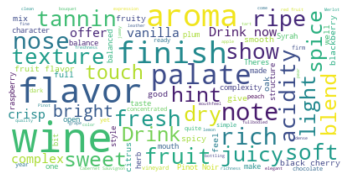

Cluster: 2


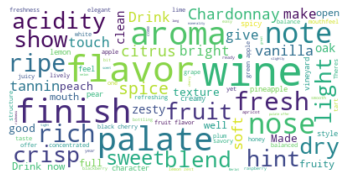

Cluster: 3


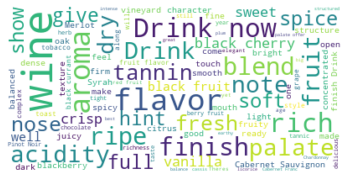

Cluster: 4


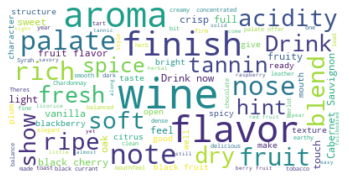

Cluster: 5


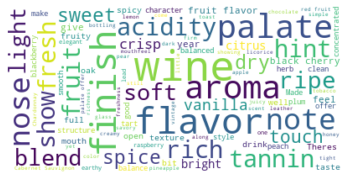

Cluster: 6


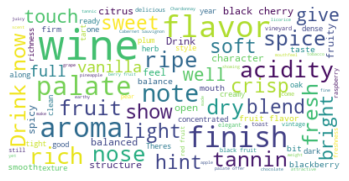

In [149]:
Kmeans_clustering_wordclouds(6)

These clusters don't seem to be entirely meaningful. If given more time, I would have added stopwords such a `wine`, `finish`, `aroma`, `drink`, `flavor` because they aren't flavor notes themselves with very little information. Secondly, even though Doc2Vec is a very effective text embedding method, there wasn't sufficient time to illustrate the effectiveness of these embeddings. If the embedding itself was not good enough to capture the semantics of descriptions, then there is no way that the clustering would have been effective. 

## 4.2 Visualize the clustered data

http://projector.tensorflow.org/

In [105]:
# save embeddings as tsv for tensorboard projector
np.savetxt('embeddings.tsv', 
           description_vecs, 
           delimiter = '\t',
           header = '\t'.join([('dim'+str(i+1)) for i in range(30)])
          )

In [98]:
# save metadata as tsv for tensorboard projector
metadata = dat.loc[:, ['title','description','region_variety_pair']]
metadata['kmeans_cluster'] = labels
metadata.head(5)

,title,description,region_variety_pair,kmeans_cluster
0,Nicosia 2013 Vulkà Bianco (Etna),"Aromas include tropical fruit, broom, brimston...","(Sicily & Sardinia-Italy, White Blend)",0
1,Quinta dos Avidagos 2011 Avidagos Red (Douro),"This is ripe and fruity, a wine that is smooth...","(Douro-Portugal, Portuguese Red)",0
2,Rainstorm 2013 Pinot Gris (Willamette Valley),"Tart and snappy, the flavors of lime flesh and...","(Oregon-US, Pinot Gris)",0
3,St. Julian 2013 Reserve Late Harvest Riesling ...,"Pineapple rind, lemon pith and orange blossom ...","(Michigan-US, Riesling)",2
4,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,"Much like the regular bottling from 2012, this...","(Oregon-US, Pinot Noir)",2


In [99]:
metadata.to_csv('metadata.tsv', sep = '\t')

Time is limited so I didn't figure out a way to embed the [tensorflow embeddings projector](http://projector.tensorflow.org/) into this notebook. But during discussion I can open up a window to demonstrate. 

### If given more time for Part 4: 

- I would done some hyperparameter tuning on the `Doc2Vec` model to make sure that the embeddings are good. This might involve using the built in methods of the `gensim` library such as `<model>.most_similar()` to see whether similar descriptions are indeed semantically similar to a human reader. 

- I also would've worked some hyperparameter tuning on the `k` parameter of the `k-means` algorithm, using the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)#:~:text=In%20cluster%20analysis%2C%20the%20elbow,number%20of%20clusters%20to%20use.), for example. 